In [1]:
import numpy as np
from utils import *
import pandas as pd
from sklearn.metrics import confusion_matrix

data = pd.read_table("data/web_crowd.txt", header=None)
truth = pd.read_table("data/web_truth.txt", header=None)


In [2]:
import matplotlib.pyplot as plt


In [3]:
truth = truth.drop_duplicates()

In [4]:
n, m, k = np.max(np.array(data), axis=0)
print(n, m, k)


2665 177 5


In [5]:
labels = transform_data(data)
labels

array([[ 4,  0,  0, ..., -1, -1, -1],
       [ 4, -1,  0, ...,  2,  1, -1],
       [ 4, -1, -1, ..., -1,  3, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int64)

In [6]:
np.any(np.max(labels,axis=1)==-1)

False

In [7]:
ranking = np.argsort(truth[1])

In [8]:
merged = data.merge(truth,on=0)


In [9]:
# proportion of missing values
missing = np.mean(labels == -1)
print(missing)

0.9669984418227494


In [10]:
# total error rate
error = np.mean(merged["1_y"] != merged[2])
print(error)

0.4484844584593603


In [11]:
confusion_matrix(merged["1_y"], merged[2])


array([[1053,  282,  149,  151,  251],
       [ 395, 1231,  454,  308,  415],
       [ 242,  496, 1671,  822,  835],
       [  71,  158,  434, 1616,  853],
       [  88,   80,  120,  365, 2999]], dtype=int64)

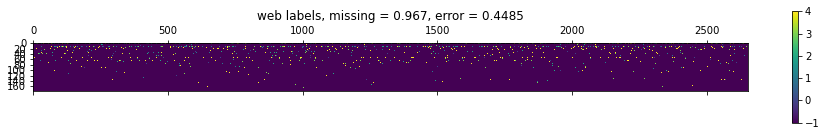

In [12]:
plt.matshow(labels[:,ranking])
plt.title("web labels, missing = "+str(np.round(missing, 4)) +
          ", error = "+str(np.round(error, 4)))
plt.colorbar()
plt.savefig("pic/web_labels.png", dpi=300)
plt.show()


In [13]:
groups = np.array([i % 3 for i in range(m)])


In [14]:
C_estimated = get_confusion_matrix(k, labels, groups=groups, sym=False)


In [15]:
i = 10
truth_new = truth[truth[0].isin(data[data[1] == i+1][0])]
pred_new = data[data[1] == i+1][data[data[1] == i+1][0].isin(truth_new[0])]


In [22]:
C = confusion_matrix(truth_new[1], pred_new[2]).T


In [23]:
confusion_matrix(truth_new[1], pred_new[2]).T

array([[17, 10,  3,  4,  3],
       [ 7, 15,  8,  2,  1],
       [ 4, 21, 41, 26,  8],
       [12, 10, 42, 44, 33],
       [ 6,  9,  7, 17, 54]], dtype=int64)

In [24]:
np.round(C / np.sum(C, axis=0)[np.newaxis, :], 5)


array([[0.36957, 0.15385, 0.0297 , 0.04301, 0.0303 ],
       [0.15217, 0.23077, 0.07921, 0.02151, 0.0101 ],
       [0.08696, 0.32308, 0.40594, 0.27957, 0.08081],
       [0.26087, 0.15385, 0.41584, 0.47312, 0.33333],
       [0.13043, 0.13846, 0.06931, 0.1828 , 0.54545]])

In [25]:
np.round(C_estimated[i], 5)


array([[0.50143, 0.17704, 0.     , 0.00921, 0.03241],
       [0.     , 0.38608, 0.02879, 0.0397 , 0.     ],
       [0.14226, 0.19998, 0.55926, 0.30365, 0.     ],
       [0.3329 , 0.08476, 0.34336, 0.58011, 0.32056],
       [0.0234 , 0.15215, 0.06858, 0.06733, 0.64703]])

In [33]:
def get_true_confusion_matrix(data, truth, normalize=True):
    truth = truth.drop_duplicates()
    n, m, k = np.max(np.array(data), axis=0)
    C = np.zeros((m, k, k))
    for i in range(m):
        truth_new = truth[truth[0].isin(data[data[1] == i+1][0])]
        pred_new = data[data[1] == i +
                        1][data[data[1] == i+1][0].isin(truth_new[0])]
        Ci = confusion_matrix(truth_new[1], pred_new[2], labels=[
                              i+1 for i in range(k)]).T
        if normalize:
            Ci = Ci.astype(float)
            colsums = np.sum(Ci, axis=0)
            Ci[:, colsums != 0] /= colsums[np.newaxis, colsums != 0]
        C[i, :, :] = Ci
    return C


In [27]:
def confusion_matrix_loss(C_estimated,C_true):
    return np.mean((C_estimated-C_true)**2)


In [98]:
def get_confusion_matrix(k, labels, groups=None, sym=True, cutoff=1e-7, L=20, N=100, seed=None):
    m, n = labels.shape
    if seed is not None:
        np.random.seed(seed)
    if groups is None:
        groups = np.random.randint(3, size=m)
    Zg = get_Zg(k, labels, groups)
    M2s, M3s = get_M(Zg)
    Cc = np.zeros((3, k, k))
    W = np.zeros((3, k))
    for g, (M2, M3) in enumerate(zip(M2s, M3s)):
        Q = get_whiten(M2, sym)
        M3_whiten = whiten_tensor(M3, Q)
        values, vectors = robust_tensor_power(M3_whiten, L, N, sym)
        w = values**-2
        mu = np.linalg.inv(Q.T)@vectors@np.diag(values)
        best = np.argmax(mu, axis=0)
        
        # prevent multiple mu in same column
        for l in range(k):
            loc = np.where(best == l)[0]
            if len(loc)==1:
                Cc[g, :, l] = mu[:, loc].ravel()
                W[g, l] = w[loc]
            elif len(loc)==0:
                loc = np.random.randint(k)
                Cc[g, :, l] = mu[:, loc].ravel()
                W[g, l] = w[loc]
            else:
                loc = np.random.choice(loc,1)
                Cc[g, :, l] = mu[:, loc].ravel()
                W[g, l] = w[loc]

    W = np.mean(W, axis=0)
    C = np.zeros((m, k, k))
    for i in range(m):
        Ca = (np.sum(Cc, axis=0)-Cc[groups[i], :, :])/2
        Za = (np.sum(Zg, axis=0)-Zg[groups[i], :, :])/2
        E = np.zeros((k, k))
        for j in range(n):
            if labels[i, j] != -1:
                E[labels[i, j], :] += Za[j, :]
        E /= n
        Ci = E@np.linalg.inv(W[np.newaxis,:]*Ca.T)
        if cutoff:
            Ci[Ci < cutoff] = cutoff
        colsums = np.sum(Ci, axis=0)
        Ci /= colsums[np.newaxis, :]
        C[i, :, :] = Ci
    return C


In [86]:
a = np.array([1,2,3,3,5])
np.where(a == 3)[0].ravel()


array([2, 3], dtype=int64)

In [82]:
np.where(a == 3)[0]


array([2, 3], dtype=int64)

In [30]:
truth_new[1].drop_duplicates().sort_values()

119    1
76     2
123    3
13     4
6      5
Name: 1, dtype: int64

In [36]:
C_true = get_true_confusion_matrix(data, truth)


In [99]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, groups=groups, sym=False), C_true)


0.049672919187164974

In [100]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, sym=False,seed=123), C_true)


0.09706994087371096

In [214]:
# symmetric or not
iternum = 500
sym_losses = np.zeros(iternum)
asym_losses = np.zeros(iternum)
for i in range(iternum):
    sym_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True), C_true)
    asym_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=False), C_true)


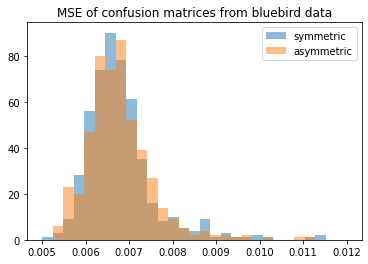

In [220]:
bins = np.linspace(0.005, 0.012, 30)
plt.hist(sym_losses,bins, alpha=0.5, label='symmetric')
plt.hist(asym_losses, bins, alpha=0.5, label='asymmetric')
plt.title("MSE of confusion matrices from web data")
plt.legend(loc='upper right')
plt.savefig("pic/web_symmetry.png",dpi=300)
plt.show()

From the plot we can see if we symmetricalize the matrices and tensors, the MSE of the confusion matrices can be reduced.